# Compare sea surface height model output and observations

Comparing the sea-surface height (ssh) from two different resolution runs. Specifically plot the time-mean and standard deviation of ssh and compare to to observations from the AVISO dataset.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import cosima_cookbook as cc
import numpy as np
import glob

import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm

from dask.distributed import Client

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37699/status,
Dashboard: /proxy/37699/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34801,Workers: 7
Dashboard: /proxy/37699/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:36863,Total threads: 4
Dashboard: /proxy/43827/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:45437,


## Start a cookbook database session

In [5]:
session = cc.database.create_session()

Here we pick a `start_time` and `end_time`. We select *only* 5 years of daily data for simplicity in this example. But you can probably extend the `end_time` until the end of 2018 (for model outputs) and up to middle of 2020 for observations!

In [6]:
#SSH variable in ACCESS-OM2 models
variable = 'sea_level'

# dates to match the AVISO record
start_time = '1993-01-01'
end_time = '2018-12-31'
end_time = '1997-12-31'

## SSH from 1$^{\circ}$ model output

Here we can specify the rough start and end times using the "start_time" and "end_time" arguments. But, this yields a dataset that has an extra 12 months on either end, so we slice the data to match the AVISO dataset below.

In [7]:
experiment = '1deg_jra55_iaf_omip2_cycle6'  # 1-deg experiment
ssh1 = cc.querying.getvar(experiment, variable, session, frequency='1 daily',
                          start_time=start_time, end_time=end_time)

ssh1 = ssh1.sel(time=slice(start_time, end_time)) # slice to the same time range as AVISO
ssh1

<xarray.DataArray 'sea_level' (time: 1826, yt_ocean: 300, xt_ocean: 360)>
dask.array<getitem, shape=(1826, 300, 360), dtype=float32, chunksize=(1, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time      (time) datetime64[ns] 1993-01-01T12:00:00 ... 1997-12-31T12:00:00
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_surface_height_above_geoid
    ncfiles:        ['/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cy...
    contact:        Hakase Hayashida
    email:          hakase.hayashida@utas.edu.au
    created:        2021-03-03
    description:    1 degree ACCESS-OM2 global model configuration under inte...

## SSH from 0.25$^{\circ}$ model output

In [8]:
experiment = '025deg_jra55_iaf_omip2_cycle6'  # 0.25-deg experiment
ssh025 = cc.querying.getvar(experiment, variable, session, frequency='1 daily',
                            start_time=start_time, end_time=end_time)

ssh025 = ssh025.sel(time=slice(start_time, end_time)) # slice to the same time range as AVISO
ssh025

<xarray.DataArray 'sea_level' (time: 1826, yt_ocean: 1080, xt_ocean: 1440)>
dask.array<getitem, shape=(1826, 1080, 1440), dtype=float32, chunksize=(1, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 1993-01-01T12:00:00 ... 1997-12-31T12:00:00
Attributes:
    long_name:      effective sea level (eta_t + patm/(rho0*g)) on T cells
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_surface_height_above_geoid
    ncfiles:        ['/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_om...
    contact:        Ryan Holmes
    email:          ryan.holmes@unsw.edu.au
    created:        2020-11-03
    description:    0.25 degree ACCESS-OM2 global model configuration under i...

## CMEMS satellite observational data (former AVISO+ dataset)

Load the CMEMS dataset and select `adt` the sea surface height variable name.

In [9]:
filenames = glob.glob("/g/data/ua8/CMEMS_SeaLevel/timeseries/*.nc")
cmems = xr.open_mfdataset(filenames, parallel=True)

obs_ssh = cmems.adt
obs_ssh = obs_ssh.sel(time=slice(start_time, end_time))
obs_ssh = obs_ssh.rename('adt_cmems')
obs_ssh

<xarray.DataArray 'adt_cmems' (time: 1826, latitude: 720, longitude: 1440)>
dask.array<getitem, shape=(1826, 720, 1440), dtype=float64, chunksize=(366, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 1997-12-31
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Attributes:
    standard_name:  sea_surface_height_above_geoid
    long_name:      Absolute dynamic topography
    units:          m
    grid_mapping:   crs
    comment:        The absolute dynamic topography is the sea surface height...

Compute the mean and standard deviations to plot.

**Note**: The following cells might take a while, depending how much data you loaded. (for 5 years of daily data ~7min for 0.25 model output.

In [10]:
%%time
ssh1_mean = ssh1.mean(dim='time').load()
ssh1_std = ssh1.std(dim='time').load()

CPU times: user 8.45 s, sys: 723 ms, total: 9.17 s
Wall time: 9.42 s


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [11]:
%%time
ssh025_mean = ssh025.mean(dim='time').load()
ssh025_std = ssh025.std(dim='time').load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


CPU times: user 6min 2s, sys: 20.8 s, total: 6min 22s
Wall time: 6min 15s


In [12]:
%%time
obs_ssh_mean = obs_ssh.mean(dim='time').load()
obs_ssh_std = obs_ssh.std(dim='time').load()

CPU times: user 27.9 s, sys: 8.06 s, total: 36 s
Wall time: 2min 27s


## Plot and compare

Plot the time-mean and standard deviation of both of the model outputs and the CMEMS observational dataset (former AVISO+).

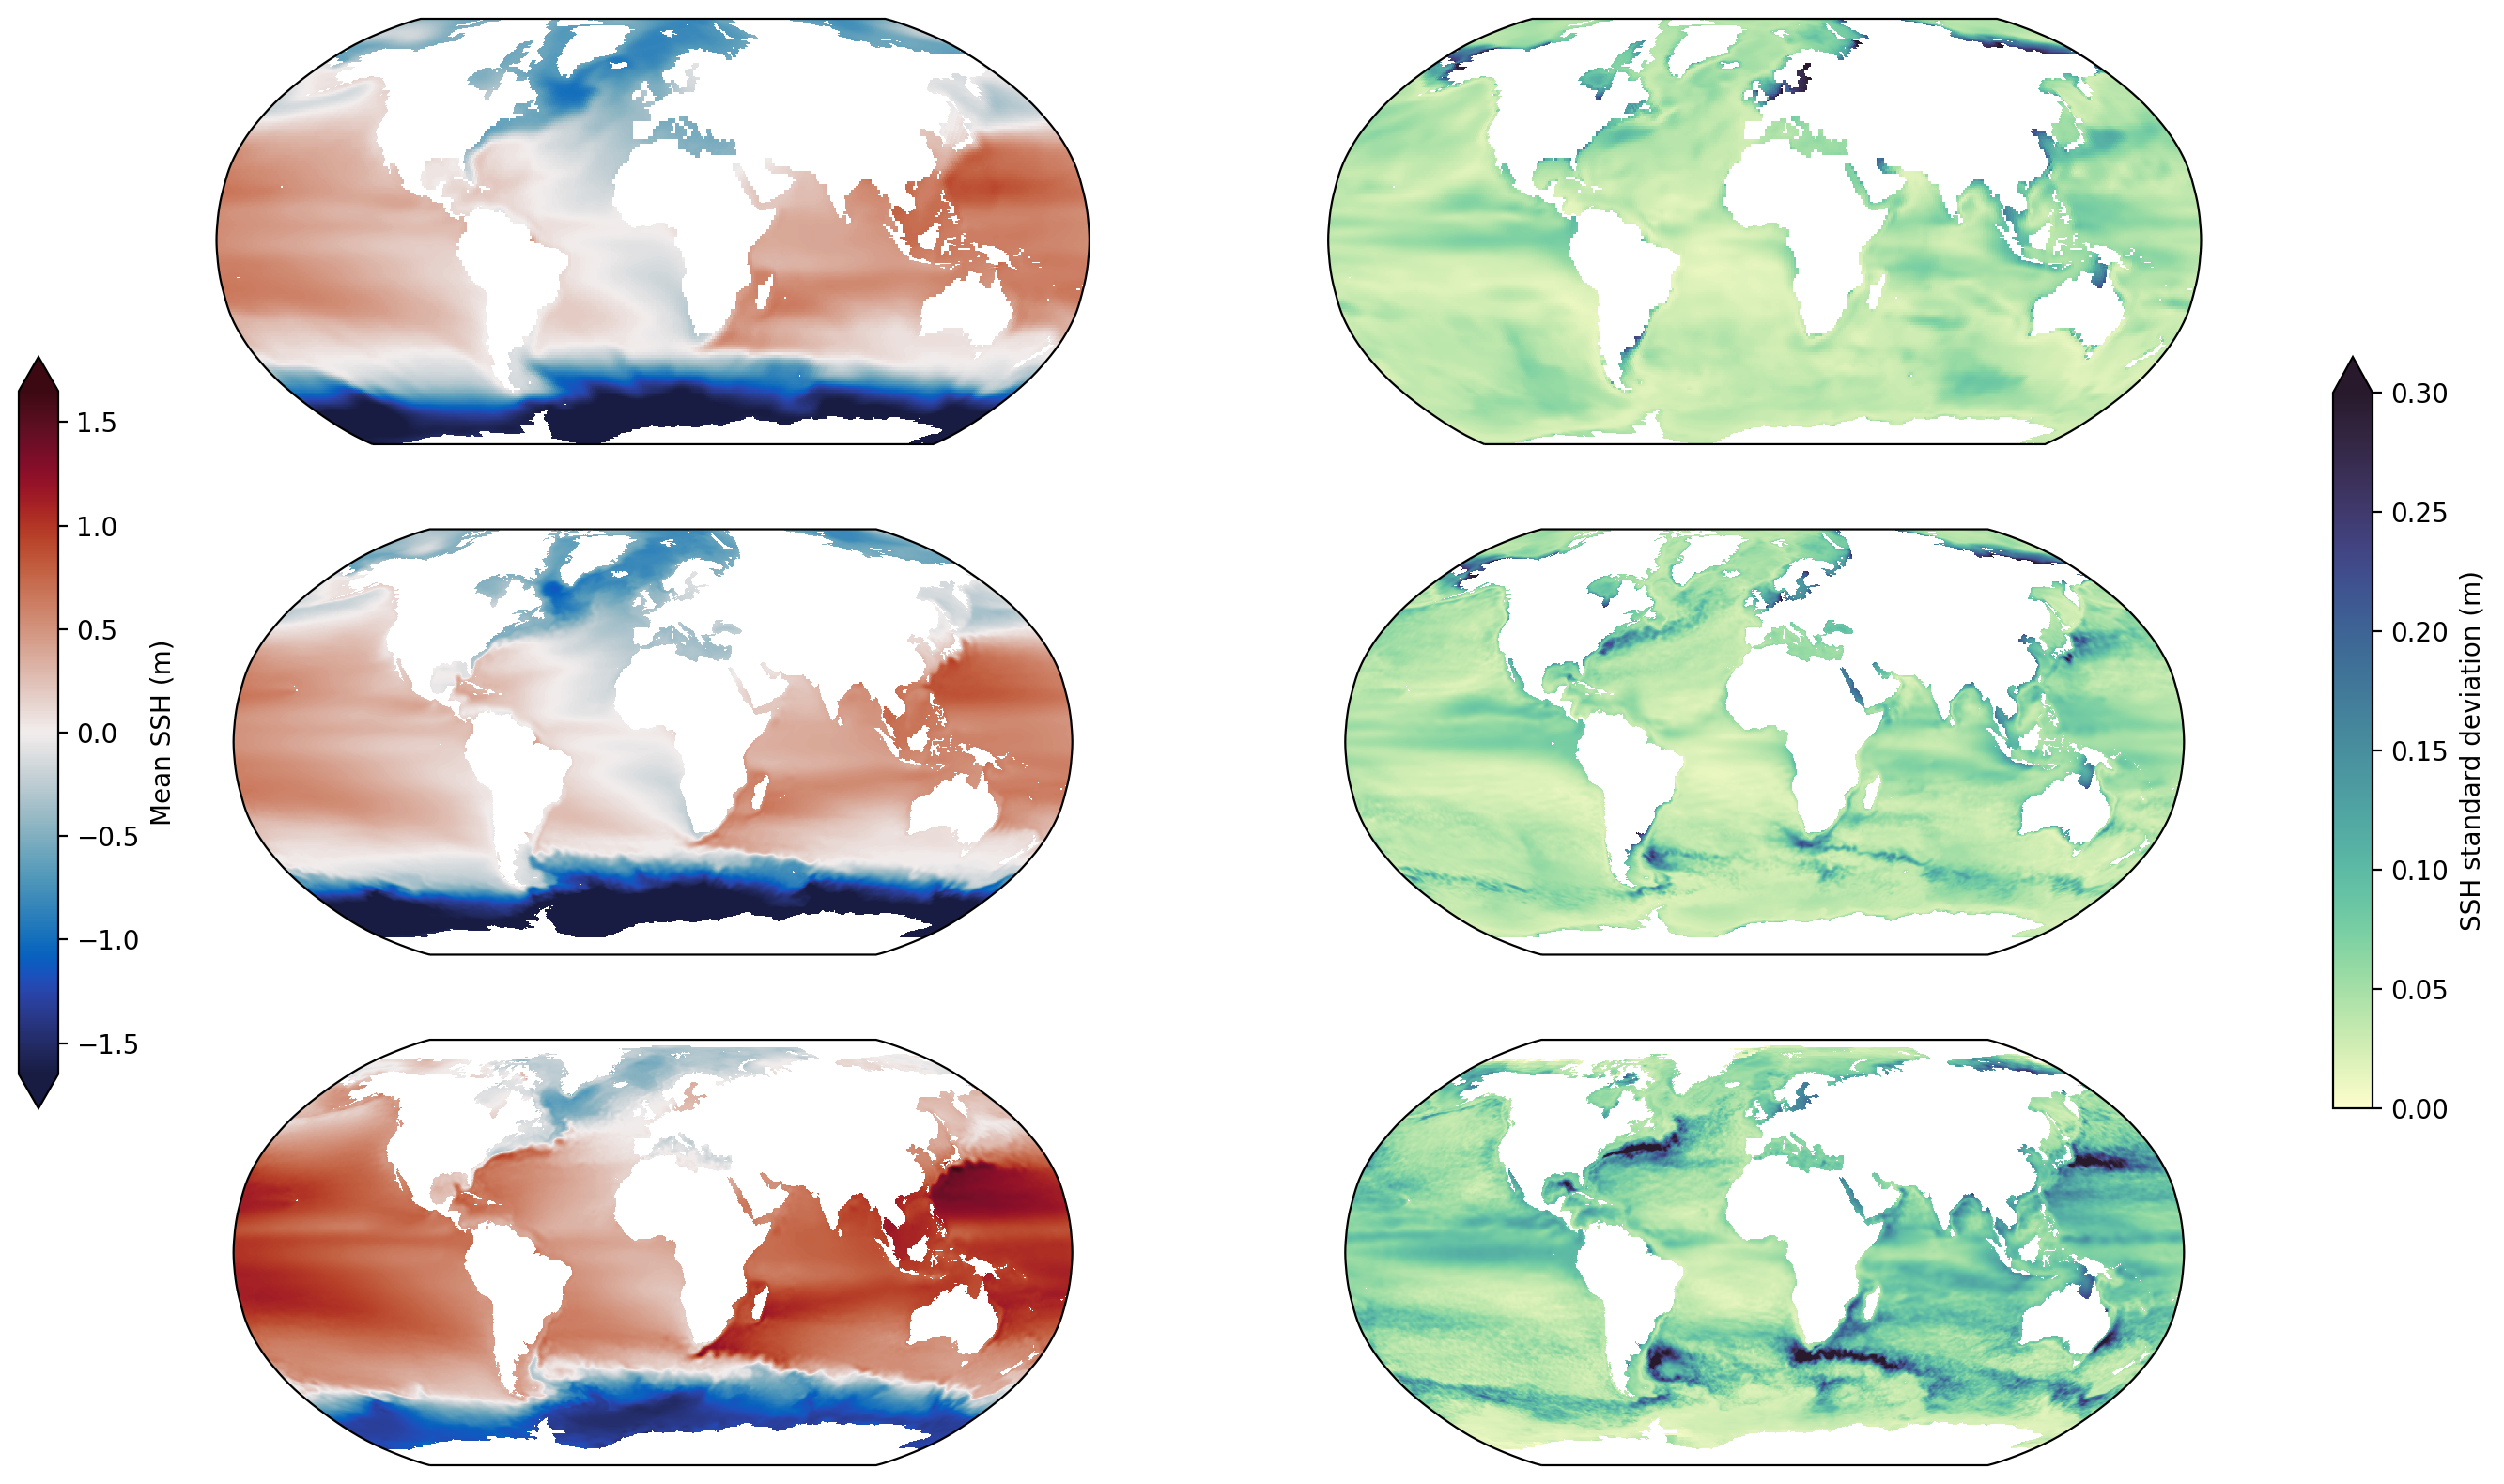

In [ ]:
projection = ccrs.Robinson(central_longitude=-100)

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (14, 10),
                         subplot_kw={'projection': ccrs.Robinson()})

# Define the contour levels and spacing 
mlev = np.arange(-1.6, 1.6, 0.02)  # levels for mean ssh
slev = np.arange( 0.0, 0.3, 0.01)  # levels for std ssh

# mean SSH plots
ax = axes[0, 0]
ax.set_title('mean SSH 1$^{\circ}$')
p1 = ssh1_mean.plot(ax=ax,
                    cmap=cm.cm.balance, vmin=-1.65, vmax=1.65, add_colorbar=False,
                    transform=ccrs.PlateCarree())

ax = axes[1, 0]
ax.set_title('mean SSH 0.25$^{\circ}$')
p1 = ssh025_mean.plot(ax=ax,
                      cmap=cm.cm.balance, vmin=-1.65, vmax=1.65, add_colorbar=False,
                      transform=ccrs.PlateCarree())

ax = axes[2, 0]
ax.set_title('CMEMS obs mean SSH')
p1 = obs_ssh_mean.plot(ax=ax,
                       cmap=cm.cm.balance, vmin=-1.65, vmax=1.65, add_colorbar=False,
                       transform=ccrs.PlateCarree())

# std SSH plots
ax = axes[0, 1]
ax.set_title('SSH standard deviation 1$^{\circ}$')
p2 = ssh1_std.plot(ax=ax,
                   cmap=cm.cm.deep, vmin=0, vmax=0.3, add_colorbar=False,
                   transform=ccrs.PlateCarree())

ax = axes[1, 1]
ax.set_title('SSH standard deviation 0.25$^{\circ}$')
p2 = ssh025_std.plot(ax=ax,
                     cmap=cm.cm.deep, vmin=0, vmax=0.3, add_colorbar=False,
                     transform=ccrs.PlateCarree())


ax = axes[2, 1]
ax.set_title('CMEMS obs SSH Standard Deviation')
p2 = obs_ssh_std.plot(ax=ax,
                      cmap=cm.cm.deep, vmin=0, vmax=0.3, add_colorbar=False,
                      transform=ccrs.PlateCarree())

# Colorbars
ax_cb1 = plt.axes([0.06, 0.3, 0.015, 0.4])
cb = plt.colorbar(p1, cax=ax_cb1, extend='both',label='Mean SSH (m)')

ax_cb2 = plt.axes([0.94, 0.3, 0.015, 0.4])
cb = plt.colorbar(p2, cax=ax_cb2, extend='max',label='SSH standard deviation (m)');